# Data Cleaning
---

I'll be making use of five datasets: (1) attack_label (2) toxic_label (3) aggress_label (4) attack_comment, and (5) ao3_test. The first four were provided under the [Wikipedia Detox project](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release), which provides over 100,000 Wikipedia discussion comments human-labeled for toxicity, aggression, and whether the comment constituted a personal attack.

The ao3_test dataset comprises 320 comments from [Archive of Our Own](https://archiveofourown.org/) (Ao3), a platform which allows writers to self-publish fanfiction, that I've manually compiled and labeled for abusive language towards fanfiction authors.

### Contents
- [Cleaning attack_label](#attack_label)
- [Cleaning toxic_label](#toxic_label)
- [Cleaning_aggress_label](#aggress_label)
- [Cleaning attack_comment](#attack_comment)
- [Merging Wikipedia datasets](#merge_wiki)
- [Cleaning ao3_comment](#ao3_comment)
- [Data dictionary](#data_dictionary)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emot

In [2]:
# Reading data into Pandas dataframes
ao3_comment = pd.read_csv("../datasets/raw/ao3_comments.csv")
attack_label = pd.read_csv("../datasets/raw/attack_annotations.tsv", sep = "\t", index_col = False, engine = "python")
toxic_label = pd.read_csv("../datasets/raw/toxicity_annotations.tsv", sep = "\t", index_col = False, engine = "python")
aggress_label = pd.read_csv("../datasets/raw/aggression_annotations.tsv", sep = "\t", index_col = False, engine = "python")
attack_comment = pd.read_csv("../datasets/raw/attack_annotated_comments.tsv", sep = "\t", index_col = False, engine = "python")

<a name = "attack_label"></a>
### Cleaning attack_label dataset
The attack_label, toxic_label, and aggress_label datasets show the scoring given to each Wikipedia discussion comment. Each comment was labeled by 10 different workers and is referred to by a rev_id.

As seen in the attack_label dataset below, the comment text itself was not included in the label datasets. It is stored in the attack_comment dataset instead. Workers were asked to score 0 or 1 if a comment was a personal attack. If a comment was scored 1 for attack, the worker was also asked to indicate what kind of attack it was out of 4 options:
- **recipient_attack:** Targeted at recipient (e.g. "you suck")
- **third_party_attack:** Targeted at a third party (e.g. "Bob sucks")
- **quoting_attack:** Being reported or quoted (e.g. "Bob said Henri sucks")
- **other_attack:** Another kind of attack or harassment

In [3]:
# Taking preliminary look at the data
attack_label.head(15)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0
5,37675,176,0.0,0.0,0.0,0.0,0.0
6,37675,481,0.0,0.0,0.0,0.0,0.0
7,37675,487,0.0,0.0,0.0,0.0,0.0
8,37675,578,0.0,0.0,0.0,0.0,0.0
9,37675,1127,0.0,0.0,0.0,0.0,0.0


There are a number of cleaning steps that need to be performed:
- Ratings need to be averaged for each rev_id
    - I'd like to keep the averaged attack column as a new column `attack_score`
    - The `attack` column should be 1 if the majority of workers scored it as 1, else it should be 0
    - Type of attack (e.g. `quoting_attack` or `other_attack`) will be kept as the mean score across all workers 
- As the worker_id column is not needed, it will be dropped
- Check if there are missing values that should be imputed
- Check if variable types are correct

In [4]:
# Aggregating rows by rev_id
attack_label = attack_label.groupby("rev_id", as_index = False).mean()

# Renaming column containing non-binarized attack average to "attack_score"
attack_label.rename(columns = {"attack": "attack_score"}, inplace = True)

# Create new attack column which will be 1 if majority scored 1, 0 otherwise
attack_label["attack"] = attack_label["attack_score"].map(lambda cell: 0 if cell < 0.5 else 1)

In [5]:
# Dropping worker_id column
attack_label.drop("worker_id", axis = 1, inplace = True)

There are no missing values and the types are correct.

In [6]:
# Checking for missing values and types
attack_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115864 entries, 0 to 115863
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   rev_id              115864 non-null  int64  
 1   quoting_attack      115864 non-null  float64
 2   recipient_attack    115864 non-null  float64
 3   third_party_attack  115864 non-null  float64
 4   other_attack        115864 non-null  float64
 5   attack_score        115864 non-null  float64
 6   attack              115864 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 7.1 MB


<a name = "toxic_label"></a>
### Cleaning toxic_label dataset
Like the attack_label dataset, the scoring of each worker makes up a row in the toxic_label dataset. This time, workers were asked to score comments from a scale of -2 to 2.
- **Very Toxic (-2):** a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion
- **Toxic (-1):** a rude, disrespectful, or unreasonable comment that is somewhat likely to make you leave a discussion
- **Neither (0)**
- **Healthy (1):** a reasonable, civil, or polite contribution that is somewhat likely to make you want to continue a discussion
- **Very Healthy (2):** a very polite, thoughtful, or helpful contribution that is very likely to make you continue a discussion

If a comment was rated -2 or -1 under the toxicity_score column, it would labeled 1 under the toxicity column. Otherwise, it would be labeled 0 for the toxicity column.

In [7]:
# Taking a preliminary look at the data
toxic_label.head(5)

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


The attack column from the attack_label dataset is what will be used to classify the model, but I'd like to include the aggregated toxicity score as a feature to aid data cleaning and EDA. To facilitate the aggregation of the toxicity score, I will rescale the score as a 1 to 5 score (with 1 being very healthy and 5 being very toxic). 

There are thus the following cleaning steps that need to be performed:
- Ratings need to be averaged for each rev_id
    - `toxicity_score` should be rescaled to a scale of 1 to 5
    - Rescaled toxicity score should be averaged
- As the `worker_id` and `toxicity` columns are not needed, they will be dropped.
- Check if there are missing values that should be imputed
- Check if variable types are correct

In [8]:
# Defining function to rescale the toxicity score
def rescale_toxicity(cell):
    if cell == 2:
        return 1
    if cell == 1:
        return 2
    if cell == 0:
        return 3
    if cell == -1:
        return 4
    if cell == -2:
        return 5

In [9]:
# Applying rescale function to toxicity_score column
toxic_label["toxicity_score"] = toxic_label["toxicity_score"].apply(rescale_toxicity)

# Aggregating rows by rev_id
toxic_label = toxic_label.groupby("rev_id", as_index = False).mean()

In [10]:
# Dropping worker_id and toxicity columns
toxic_label.drop("worker_id", axis = 1, inplace = True)
toxic_label.drop("toxicity", axis = 1, inplace = True)

There are no missing values but the rev_id variable should be int type so that it is standardized with attack_label.

In [11]:
# Checking for missing values and types
toxic_label.info()

# Typecasting rev_id column to integer
toxic_label["rev_id"] = toxic_label["rev_id"].astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159686 entries, 0 to 159685
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   rev_id          159686 non-null  float64
 1   toxicity_score  159686 non-null  float64
dtypes: float64(2)
memory usage: 3.7 MB


<a name = "aggress_label"></a>
### Cleaning aggress_label dataset
Like the toxic_label dataset, the scoring of each worker makes up a row in the aggress_label dataset. This time, workers were asked to score comments from a scale of -3 to 3, with -3 as very aggressive (including passive aggression), and 3 as very friendly. If a comment was rated -3, -2 or -1 under the aggression_score column, it would labeled 1 under the aggression column. Otherwise, it would be labeled 0 for the aggression column.

In [12]:
# Taking a preliminary look at the data
aggress_label.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


The attack column from the attack_label dataset is what will be used to classify the model, but as with the toxicity score, I'd like to include the aggression score as a feature to aid in data cleaning and EDA. To facilitate the aggregation, I will rescale the aggression score as a 1 - 7 score (with 1 being very friendly and 7 being very aggressive). As the worker_id and aggression columns are not needed, they will be dropped.

There are thus the following cleaning steps that need to be performed:
- Ratings need to be averaged for each rev_id
    - `aggression_score` should be rescaled to a scale of 1 to 7
    - Rescaled aggression score should be averaged
- As the `worker_id` and `aggression` columns are not needed, they will be dropped.
- Check if there are missing values that should be imputed
- Check if variable types are correct

In [13]:
# Defining function to rescale the aggression score
def rescale_aggression(cell):
    if cell == 3:
        return 1
    if cell == 2:
        return 2
    if cell == 1:
        return 3
    if cell == 0:
        return 4
    if cell == -1:
        return 5
    if cell == -2:
        return 6
    if cell == -3:
        return 7

In [14]:
# Applying rescale function to aggression_score column
aggress_label["aggression_score"] = aggress_label["aggression_score"].apply(rescale_aggression)

# Aggregating rows by rev_id
aggress_label = aggress_label.groupby("rev_id", as_index = False).mean()

In [15]:
# Dropping worker_id and aggression columns
aggress_label.drop("worker_id", axis = 1, inplace = True)
aggress_label.drop("aggression", axis = 1, inplace = True)

After checking for missing values and variable types, there were no missing values, and the types were correct.

In [16]:
# Checking for missing values and types
aggress_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115864 entries, 0 to 115863
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_id            115864 non-null  int64  
 1   aggression_score  115864 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.7 MB


<a name = "attack_comment"></a>
### Cleaning attack_comment dataset
The attack_comment dataset stores the actual comment text, along with other information about the comment such as the year it was posted in, how it was sampled, and what set (train, test, etc.) it was assigned to in the model developed by the original authors. The last three columns are not needed and will thus be dropped.

In [17]:
# Taking a preliminary look at the data
attack_comment.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [18]:
# Dropping unneeded columns
attack_comment.drop("ns", axis = 1, inplace = True)
attack_comment.drop("sample", axis = 1, inplace = True)
attack_comment.drop("split", axis = 1, inplace = True)

Looking at the comment text, it's evident that there are a number of data cleaning steps to be performed:
- Escaped characters like NEWLINE_TOKEN and \` should be replaced with appropriate characters.
- URLs should be removed from comment text
- Multiple spacings should be reduced to single spacings
- I'd like to create a column indicating the number of words in the comment for cleaning and EDA.
- Outliers (in the form of abnormally long discussion comments) should be removed.

In [19]:
# Changing pandas setting temporarily so that full comment can be seen
pd.set_option('display.max_colwidth', 0)

# Let's look at the comments again to ascertain what needs to be cleaned
attack_comment.head()

,rev_id,comment,year,logged_in
0,37675,"`-NEWLINE_TOKENThis is not ``creative``. Those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``. If you don't understand that, fine, legitimate criticism, I'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.NEWLINE_TOKENNEWLINE_TOKENThe sentence you quote is absolutely neutral. You just aren't familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British. If that's my fault, fine, I can fix that to explain. But ther'es nothing ``personal`` or ``creative`` about it.NEWLINE_TOKENNEWLINE_TOKENI'm tired of arguing with you. Re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``. If I were to apply your standard I'd be moving ``Mutual Assured Destruction`` to ``talk`` for not appealing to a Reagan voter's biases about its effectiveness, and for dropping the ``ly``.NEWLINE_TOKENNEWLINE_TOKENThere is a double standard in your edits. If it comes from some US history book, like ``peace movement`` or 'M.A.D.' as defined in 1950, you like it, even if the definition is totally useless in 2002 and only of historical interest. NEWLINE_TOKENNEWLINE_TOKENIf it makes any even-obvious connection or implication from the language chosen in multiple profession-specific terms, you consider it somehow non-neutral... Gandhi thinks ``eye for an eye`` describes riots, death penalty, and war all at once, but you don't. What do you know that Gandhi doesn't?NEWLINE_TOKENNEWLINE_TOKENGuess what: reality is not neutral. Current use of terms is slightly more controversial. Neutrality requires negotiation, and some willingness to learn.NEWLINE_TOKENNEWLINE_TOKENThis is your problem not mine. You may dislike the writing, fine, that can be fixed. But disregarding fundamental axioms of philosphy with names that recur in multiple phrases, or failing to make critical distinctions like 'insurance' versus 'assurance' versus 'ensurance' (which are made in one quote by an Air Force general in an in-context quote), is just a disservice to the reader.NEWLINE_TOKENNEWLINE_TOKENIf someone comes here to research a topic like MAD, they want some context, beyond history.NEWLINE_TOKENNEWLINE_TOKENIf this is a history book, fine, it's a history book. But that wasn't what it was claimed to be...NEWLINE_TOKEN`",2002,False
1,44816,"`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``standard model`` is itself less NPOV than I think we'd prefer...NEWLINE_TOKENNEWLINE_TOKEN:: if it's ``new-age speak`` then a lot of old-age people speak it - Karl Popper, the Pope, etc. here's Karl Popper's view of this.NEWLINE_TOKENNEWLINE_TOKEN:: The clearest title for this article would be ``particle physics cosmology`` - but as I say that would require broader treatment of issues like the Anthropic Principle, cognitive bias beyond the particle physics zoo, etc.NEWLINE_TOKENNEWLINE_TOKEN:: as to accelerators, it's clear that while they are in use, someone is still looking for particles. So this is not yet a settled ``cosmology`` so certain that we abandon the search... nor is it an arbitrary foundation ontology as you suggest, not subject to question.`",2002,False
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the situation as of March 2002 was such: NEWLINE_TOKENA Saudi proposal of Land for Peace AND recognition by ALL arab countries was made. The day the proposal was to be made formal by the Arab League was the day the Israeli's under the command of Ariel Sharon began the invasion of the Palestinian self-rule areas. user:Arab.",2002,False
3,89320,"Next, maybe you could work on being less condescending with your suggestions about reading the naming conventions and FDL, bot

In [20]:
# Writing function to clean comment test
def clean_wiki(cell):
    
    # Replace escaped characters
    cell = cell.replace("NEWLINE_TOKEN", " ")
    cell = cell.replace("TAB_TOKEN", " ")
    cell = cell.replace("`", "'")
    cell = cell.replace("``", '"')
    
    # Remove urls from comment text
    cell = re.sub("(?<!\S)(?:http|www)(?:.*?)(?!\S)", " ", cell)
    
    # Eliminate double spacing or multiple spacing
    cell = re.sub("\s\s+", " ", cell)
    return cell

# Applying function to clean comment column
attack_comment["comment"] = attack_comment["comment"].apply(clean_wiki)

# Creating comment length feature
attack_comment["comment_len"] = attack_comment["comment"].apply(len)

As can be seen in the boxplot below, there are a large number of outliers that stretch as long as 10,000 characters (the max character length for Wikipedia discussion comments). Viewing the comments with the longest lengths reveals that they are mostly spam comments with heavy repetition of words. This could adversely skew word counts after count vectorizers are applied to the comments. As such, I have decided to remove all comments that fall outside a mean +- 3SD range.

<AxesSubplot:>

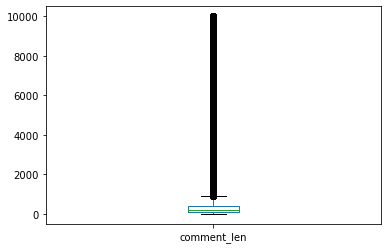

In [21]:
attack_comment["comment_len"].plot(kind="box")

In [22]:
attack_comment.sort_values("comment_len").tail()

rev_id  \
12983  58224447    
90765  489080105   
6121   34581073    
15167  64963167    
58706  274599352   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [23]:
# Printing values for mean +- 3SD
len_mean = attack_comment["comment_len"].mean()
len_sd = attack_comment["comment_len"].std()
print("Mean - 3SD = ", len_mean - (3*len_sd))
print("Mean + 3SD = ", len_mean + (3*len_sd))

# Dropping comments with lengths exceeding 2646 characters
attack_comment.drop(attack_comment.index[attack_comment["comment_len"]>len_mean + (3*len_sd)], inplace = True)

Mean - 3SD =  -1802.3291551731527
Mean + 3SD =  2612.674232159965


After checking for missing values and variable types, there are no missing values but I decided to map logged_in to 0/1 values (as opposed to True/False) to keep it consistent with other datasets.

In [24]:
#Checking for missing values and types
attack_comment.info()

# Mapping logged_in to binary values
attack_comment["logged_in"] = attack_comment["logged_in"].map(lambda cell: 1 if cell == True else 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113784 entries, 0 to 115863
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   rev_id       113784 non-null  int64 
 1   comment      113784 non-null  object
 2   year         113784 non-null  int64 
 3   logged_in    113784 non-null  bool  
 4   comment_len  113784 non-null  int64 
dtypes: bool(1), int64(3), object(1)
memory usage: 4.4+ MB


<a name = "merge_wiki"></a>
### Merging Wikipedia datasets
As the label datasets contain  the scoring for each comment but not the comment text itself, and attack_comment contains the comment text but not the scoring, the four datasets need to be merged into one dataset. I will merge the datasets via an inner join as I only want rows that have values for all of the columns.

In [25]:
# Merging datasets
df = pd.merge(attack_label, toxic_label, on = "rev_id")
df = pd.merge(df, aggress_label, on = "rev_id")
df = pd.merge(df, attack_comment, on = "rev_id")

In [26]:
# Changing pandas setting back to default setting for visibility
pd.set_option('display.max_colwidth', 50)

# Taking a preliminary look at the merged dataset
df.head()

,rev_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack_score,attack,toxicity_score,aggression_score,comment,year,logged_in,comment_len
0,37675,0.0,0.0,0.000000,0.0,0.000000,0,2.7,4.000000,'- This is not ''creative''. Those are the dic...,2002,0,2371
1,297866,0.0,0.0,0.000000,0.0,0.000000,0,2.8,3.888889,"Ummm. The article uses imperial measurements,...",2001,1,118
2,360594,0.0,0.0,0.000000,0.0,0.000000,0,2.6,4.000000,::I disagree. I would leave it out of the int...,2002,0,346
3,377054,0.0,0.0,0.000000,0.0,0.000000,0,2.6,4.000000,:::I don't know where you got the idea that M...,2002,0,220
4,661509,0.0,0.0,0.111111,0.0,0.111111,0,2.8,3.888889,MarcusAurelius]] Why exactly was this user ban...,2003,0,51


There are a number of data cleaning steps to be performed:
- Data should be cleaned by excluding outliers
    - Check comments flagged as attacks that are low in toxicity or aggression
    - Check comments flagged as healthy that are high in toxicity or aggression
- Check for missing values
- Check variable types
- Undersample majority class to balance dataset

From the box plot below, we can see that there are a number of outliers in the dataset. There were comments labeled as attacks that were low in toxicity, and also comments not labeled as attacks that were high in toxicity.

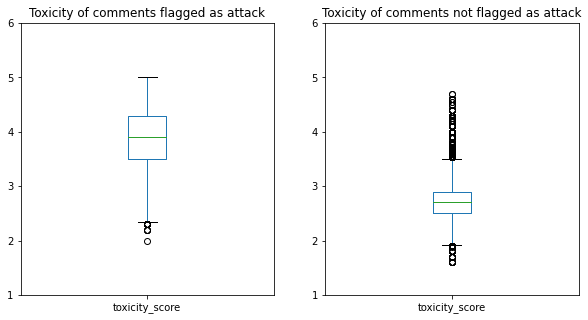

In [27]:
# Plotting boxplot of toxicity for comments labelled as attack
plt.subplot(1,2,1)
plt.ylim(1,6)
plt.title("Toxicity of comments flagged as attack")
df[df["attack"]==1]["toxicity_score"].plot(kind = "box", figsize = [10,5])

# Plotting boxplot of toxicity for comments labelled as non-attack
plt.subplot(1,2,2)
plt.ylim(1,6)
plt.title("Toxicity of comments not flagged as attack")
df[df["attack"]==0]["toxicity_score"].plot(kind = "box", figsize = [10,5]);

Below we can see some of the comments that were labelled as NOT an attack by the majority of workers. However, it looks as if a number of these comments SHOULD be classified as attacks, as they are targeted at a recipient (e.g. "you are dumb" in the first row).

In [28]:
# Displaying rows that represent unflagged comments that are high in toxicity
df[df["attack"]==0].sort_values("toxicity_score", ascending = False).head().iloc[:,-8:-3]

,attack_score,attack,toxicity_score,aggression_score,comment
13461,0.222222,0,4.7,4.444444,HOPE YOUR HEAD GETS CUT OFF AND SOMEONE WIPES...
38594,0.444444,0,4.7,5.000000,== you are dumb == Mexican Punk is the god of...
51216,0.300000,0,4.6,4.600000,"::Haha, I fucking pissed myself reading this ..."
67351,0.444444,0,4.6,5.555556,"you people are cunts, bombing every ones mail ..."
61289,0.444444,0,4.6,5.333333,:I am also a sockpuppet of CUTKD. Before you ...


On the flip side, comments labeled as attacks that were low in toxicity seemed misclassified (as in the first instance), or else seemed like attempts to get moderators to act against aggressive and unreasonable users.

In [29]:
# As comments are too long to fit in a dataframe, this prints out each comment more visibly
for comment in df[df["attack"]==1].sort_values("toxicity_score").head(4)["comment"]:
    print(comment, "\n")

 :Glad I could help. I've been keeping an eye on as much of the Medal of Honor stuff as I can.  

 Mr.Bishonen! & Joshua Jonathan, I don't understand why are you doing all these for me.Speaking harshly in the talk page because of not controlling my anger once long before can't be given unlimited ban for topic.If you keep doing this to every user.Then there will be no user left in wikipedia.Being an administrator you can't do such unjustice to users.It is total unjustice to a user.You please think of it, i haven't vandalised any articles in wikipedia, you can check them.Why i can't edit wikipedia articles, please think of it, what you are doing is not fair.Please relieve me from block and topic ban.Thank you, that you have atleast given me chance to write in my talk page. -abcde  

 == Help needed - Edit war 2 - Aggressive and Incompetent Edits by User Verbal == I am requesting help with an over-aggressive and inconsiderate editor by the name of VERBAL. This person keeps reverting a pag

I thus decided to remove comments flagged as attacks that had a toxicity score less than mean - 3SD, and comments NOT flagged as attacks that had a toxicity score more than mean + 3SD.

In [30]:
# Dropping rows that are outliers in terms of toxicity score
att_toxic = df[df["attack"]==1]["toxicity_score"]
not_att_toxic = df[df["attack"]==0]["toxicity_score"]

df.drop(df.index[(df["attack"]==1) & (df["toxicity_score"]< att_toxic.mean() - 3*att_toxic.std())], inplace = True)
df.drop(df.index[(df["attack"]==0) & (df["toxicity_score"]> not_att_toxic.mean() + 3*not_att_toxic.std())], inplace = True)

Repeating the process with aggression scores, there were no outliers for comments that were flagged as attacks. However, there were comments NOT flagged as attacks that were rated as high in aggression.

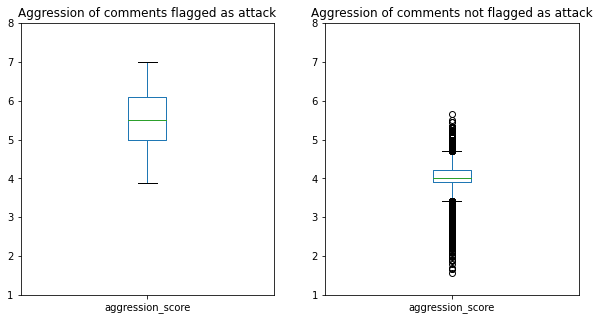

In [31]:
# Plotting boxplot of aggression for comments labelled as attack
plt.subplot(1,2,1)
plt.ylim(1,8)
plt.title("Aggression of comments flagged as attack")
df[df["attack"]==1]["aggression_score"].plot(kind = "box", figsize = [10,5])

# Plotting boxplot of aggression for comments labelled as non-attack
plt.subplot(1,2,2)
plt.ylim(1,8)
plt.title("Aggression of comments not flagged as attack")
df[df["attack"]==0]["aggression_score"].plot(kind = "box", figsize = [10,5]);

Comments labeled as NOT attack that were high in aggression seemed to either be misclassified (as is evident with the first and last instance below), while others seemed to be heated responses to personal attacks from others. I thus decided to remove unflagged comments that had aggression scores above mean + 3SD.

In [32]:
# As comments are too long to fit in a dataframe, this prints out each comment more visibly
for comment in df[df["attack"]==0].sort_values("aggression_score", ascending = False).head()["comment"]:
    print(comment, "\n")

 ==Message== Hey Dx927 you're a fat ugly cunt with the mental capacity of a 3-year-old amoeba. Why don't you get a life and stop trolling wikipedia you little fag?  

 == warnings????!?!?! == I have numerous warnings from you about vandilization and me being homophobic?????? I have NEVER written anything in wikipedia, why does it say that I have done all these horrible things???? I can't believe that someone would insult me on a personal level just because they assume I have done something; I am deeply hurt that you would call me homophobic- my college education is in defending people from discrimination, why on earth would i discriminate against anyone? I would also never think of vandalizing the site, i didn't even know i could delete or rewrite things on here! In using this website i understand that it is public opinion and not fact, and why would i have the right to change or vandalize anyone elses opinions and/or beliefs? If i don't agree w/ something on your site, i just go to an

In [33]:
# Dropping unflagged comments that were abnormally high in aggression
not_att_agg = df[df["attack"]==0]["aggression_score"]
df.drop(df.index[(df["attack"]==0)&(df["aggression_score"] > not_att_agg.mean() + 3*not_att_agg.std())], inplace = True)

Now that outliers have been removed, we should check for missing values and variable types. As seen below, there are no missing values since the datasets were merged via an inner join. The types are correct as well and don't have to be changed.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75650 entries, 0 to 76545
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rev_id              75650 non-null  int64  
 1   quoting_attack      75650 non-null  float64
 2   recipient_attack    75650 non-null  float64
 3   third_party_attack  75650 non-null  float64
 4   other_attack        75650 non-null  float64
 5   attack_score        75650 non-null  float64
 6   attack              75650 non-null  int64  
 7   toxicity_score      75650 non-null  float64
 8   aggression_score    75650 non-null  float64
 9   comment             75650 non-null  object 
 10  year                75650 non-null  int64  
 11  logged_in           75650 non-null  int64  
 12  comment_len         75650 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 8.1+ MB


Finally, there is an imbalance between the classes, with comments flagged as attacks making up only 20% of the dataset. However, as there is a sufficiently large amount of comments in the minority class, I will under sample the majority class to create a balanced dataset. Furthermore, as the dataset was too large for me to process the models locally, I only sampled 7,500 out of 14,000 of flagged comments, ending with a dataset of 15,000 comments.

In [35]:
print("Number of comments flagged as attacks:", len(df[df["attack"]==1]))
print("Number of comments not flagged as attacks:", len(df[df["attack"]==0]))

Number of comments flagged as attacks: 14344
Number of comments not flagged as attacks: 61306


In [36]:
#Subsetting data by attack label
df_att = df.loc[df["attack"]==1]
df_not = df.loc[df["attack"]==0]

# Randomly sampling 7,500 rows from each class without replacement
att_sampled = df_att.sample(n = 7500, random_state = 42)
not_sampled = df_not.sample(n = 7500, random_state = 42)

# Combining flagged comments with subset of unflagged comments
df_sampled = not_sampled.append(att_sampled)

# Randomly sampling 14344 rows from majority class
not_full_sample = df_not.sample(n = 14344, random_state = 42)
df_full_sampled = not_full_sample.append(df_att)

<a name = "ao3_comment"></a>
### Cleaning ao3_comment dataset
This dataset is meant purely for final stage testing and will thus not be merged into the Wikipedia discussion comments dataset. Data-cleaning steps include:
1. Creating a comment length feature for later visualization
2. Remove emojis from comment text
3. Remove urls from comment text
4. Remove multiple spacings

In [37]:
# Taking a preliminary look at the data
ao3_comment.tail()

,comment,abusive,aggressor,logged_in
315,Eeee! what a thrilling first chapter!,0,NaN,NaN
316,\nI am here and ready for the queer,0,NaN,NaN
317,I loved this! The way you described everything...,0,NaN,NaN
318,\nI read both the chapters together and this f...,0,NaN,NaN
319,"Once again a fantastic chapter, so looking for...",0,NaN,NaN


In [38]:
# Creating column indicating length of comment
ao3_comment["comment_len"] = ao3_comment["comment"].apply(len)

In [39]:
# Instantiate emot object
emot_obj = emot.core.emot()

# Defining function to remove emojis, 
def clean_ao3(cell):
    
    # This generates dictionary of emojis in cell (if any) and their meanings
    emoji_dict = emot_obj.emoji(cell)
    # This generates dictionary of emoticons in cell (if any) and their meanings
    emoticon_dict = emot_obj.emoticons(cell)
    
    # Removes emojis in cell (if any)
    if emoji_dict["value"]:
        for emoji in emoji_dict["value"]:
            cell = cell.replace(emoji, "")
    
    # Removes emoticons in cell (if any)
    if emoticon_dict["value"]:
        for emoticon in emoticon_dict["value"]:
            cell = cell.replace(emoticon, "")  
            
    # Remove urls from comment text
    cell = re.sub("(?<!\S)(?:http|www)(?:.*?)(?!\S)", " ", cell)
    
    # Eliminate double spacing or multiple spacing
    cell = re.sub("\s\s+", " ", cell)
            
    return cell

test_emot = "test :) 😀 :( 😠😐"
clean_ao3(test_emot)

'test '

In [40]:
# Apply function to replace emotes with appropriate text
ao3_comment["comment"] = ao3_comment["comment"].apply(clean_ao3)

The 160 missing values for the "aggressor" column is because the field is null for the 160 Ao3 comments that were not abusive. There are thus no missing values that need to be imputed. The types are also correct and don't have to be fixed!

In [41]:
ao3_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   comment      320 non-null    object 
 1   abusive      320 non-null    int64  
 2   aggressor    160 non-null    object 
 3   logged_in    157 non-null    float64
 4   comment_len  320 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 12.6+ KB


<a name = "data_dictionary"></a>
## Data dictionary
---

In [42]:
# Saving cleaned datasets to csv file
ao3_comment.to_csv("../datasets/clean/ao3_clean.csv", index = False)
df.to_csv("../datasets/clean/wiki_clean_full.csv", index = False)
df_sampled.to_csv("../datasets/clean/wiki_clean_sampled.csv", index = False)
df_full_sampled.to_csv("../datasets/clean/wiki_clean_full_sampled.csv", index = False)

#### Wikipedia comments
|**Variable**|**Type**|**Definition**|
|---|---|---|
|**rev_id**|integer|Unique identifier given to each comment|
|**attack**|binary|Indicates if comment was rated by majority of workers as a personal attack|
|**recipient_attack**|float|Percentage of workers who identified the comment as an attack targeted at a recipient (e.g. "you suck")|
|**third_party_attack**|float|Percentage of workers who identified the comment as an attack targeted at a third party (e.g. "Bob sucks")|
|**quoting_attack**|float|Percentage of workers who identified the comment as an attack that was reported or quoted (e.g. "Bob said Henri sucks")|
|**other_attack**|float|Percentage of workers who identified the comment as some other kind of attack or harassment|
|**toxicity_score**|float|Average score given by workers as to how toxic a comment was on a scale of 1- 5|
|**aggression_score**|float|Average score given by workers as to how aggression a comment was on a scale of 1 - 7|
|**comment**|string|Contains the text of the Wikipedia discussion comment|
|**year**|integer|Indicates the year in which the comment was made|
|**logged_in**|binary|Indicates if the user who posted the comment was logged in or anonymous|
|**comment_len**|integer|Indicates the length of the comment in number of characters|

#### Ao3 comments
|**Variable**|**Type**|**Definition**|
|---|---|---|
|**abusive**|binary|Indicates whether the comment was abusive towards the author|
|**comment**|string|Contains the text of the Ao3 comment|
|**comment_len**|integer|Indicates the length of the comment in number of characters|
|**aggressor**|string|Dataset contains abusive comments made by 4 known trolls, indicated as troll1, troll2, troll3, and troll4, with abusive comments made by unknown commenters being labeled as "unknown"|
|**logged_in**|binary|Indicates whether aggressor was logged in|